<h2>Analisi considerando le labels principali</h2>

In [2]:
# Librerie
import os

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from itertools import chain
#import plotly
#import plotly.plotly as py
#import plotly.graph_objs as go
import matplotlib.style as style

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

pd.set_option('display.max_rows', None)

In [2]:
# FUNZIONI
def summary_ratios(table):
    horizontal_total_before = total_by_column(table)
    # Normalization
    table['barely_true'] = table.apply(lambda row: round(row.barely_true / row.total, 3), axis = 1)
    table['false'] = table.apply(lambda row: round(row.false / row.total, 3), axis = 1)
    table['half_true'] = table.apply(lambda row: round(row.half_true / row.total, 3), axis = 1)
    table['mostly_true'] = table.apply(lambda row: round(row.mostly_true / row.total, 3), axis = 1)
    table['lie'] = table.apply(lambda row: round(row.lie / row.total, 3), axis = 1)
    table['true'] = table.apply(lambda row: round(row.true / row.total, 3), axis = 1)
    
    return horizontal_total_before
    
# Calcolo del totale per colonne
def total_by_column(table):
    d = pd.DataFrame([[0,0,0,0,0,0]], columns = ['lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true'])
    d.loc[0, 'lie'] = table['lie'].sum()
    d.loc[0, 'false'] =  table['false'].sum()
    d.loc[0, 'barely_true'] = table['barely_true'].sum()
    d.loc[0, 'half_true'] = table['half_true'].sum()
    d.loc[0, 'mostly_true'] = table['mostly_true'].sum()
    d.loc[0, 'true'] = table['true'].sum()
    return d
    
    
def clean_unstack(old_table):
    new_table = old_table.unstack();
    # Replace NA
    new_table = new_table.fillna(0)
    new_table.columns = ['barely_true', 'false', 'half_true', 'mostly_true', 'lie', 'true']
    return new_table


def manage_total(table, n):
    # Conteggio totali
    table['total'] = table.apply(lambda row: row.barely_true + row.false + row.half_true + row.mostly_true +
                                  row.lie + row.true, axis = 1)
    # Elimino party poco rappresentati
    table = table[table.total >= n]
    t = table
    return t

def barplot(table, x_label, y_label, title, pdf, x_size, y_size):
    pages = PdfPages("../../plots/{}.pdf".format(pdf))
    # Setting the positions and width for the bars
    pos = list(range(len(table['lie']))) 
    width = 0.15
    # Plotting the bars
    fig, ax = plt.subplots(figsize=(x_size, y_size))
    # Create a bar with lie data,
    plt.bar(pos, table['lie'], width, alpha=0.7, color='#FFDB20') 
    # Create a bar with false data,
    plt.bar([p + width for p in pos], table['false'], width, 
            alpha=0.7, color='#D79200') 
    # Create a bar with barely_true data,
    plt.bar([p + width*2 for p in pos], table['barely_true'], width, 
            alpha=0.7, color='#2D0894') 
    # Create a bar with half_true data,
    plt.bar([p + width*3 for p in pos], table['half_true'], width, 
            alpha=0.3, color='#082D91') 
    # Create a bar with barely_true data,
    plt.bar([p + width*4 for p in pos], table['mostly_true'], width, 
            alpha=0.7, color='#01030B')
    # Create a bar with barely_true data,
    plt.bar([p + width*5 for p in pos], table['true'], width, 
            alpha=0.7, color='#3978a8') 
    # Set the x, y labels
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)
    # Set the chart's title
    ax.set_title(title)
    # Set the position of the x ticks
    ax.set_xticks([p + 1.5 * width for p in pos])
    # Set the labels for the x ticks
    ax.set_xticklabels(table.index, rotation=90)
    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*6)
    plt.ylim([0, 0.6] )
    # Adding the legend and showing the plot
    plt.legend(['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True'], loc='upper left')
    plt.grid()
    pages.savefig(bbox_inches='tight');pages.close();plt.show()

    
def usa_label_map(table, label):
    scl = [
    [0.0, 'rgb(242,240,247)'],
    [0.2, 'rgb(218,218,235)'],
    [0.4, 'rgb(188,189,220)'],
    [0.6, 'rgb(158,154,200)'],
    [0.8, 'rgb(117,107,177)'],
    [1.0, 'rgb(84,39,143)']
    ]
    data = [go.Choropleth(
        colorscale = scl, autocolorscale = False, locations = table.index,
        z = table[label].astype(float), locationmode = 'USA-states', text = '',
        marker = go.choropleth.Marker(
            line = go.choropleth.marker.Line(color = 'rgb(255,255,255)', width = 2 )),
        colorbar = go.choropleth.ColorBar(title = "Occorrenze {}".format(label))
    )]
    layout = go.Layout(
        title = go.layout.Title(text = 'Distribuzione {} tra stati'.format(label)),
        geo = go.layout.Geo(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'), showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
    )
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig, filename = 'd3-cloropleth-map')

    
def print_max_label(table, label):
    print("History Vector dell'elemento con maggior numero di {} in proporzione al totale di statements:".format(label))
    print(table.loc[table[label].idxmax()])
    print("\n")

    
def heatmap(table, table_horiz, title, xlabel, ylabel, pdf_title):
    sns.set(font_scale = 1.5)
    # Lavoro sui totali verticali
    if 'total' in table.columns:
        table = table.sort_values(by=['total'], ascending=False)
        total = pd.DataFrame(table['total'])
        tot = table['total'].sum()
        display (tot)
        table = table.drop(columns = ['total']) 
        
    pages = PdfPages("../../plots/{}.pdf".format(pdf_title))
    fig = plt.figure(figsize=(20,15))
    ax1 = plt.subplot2grid((20,20), (0,0), colspan=18, rowspan=19)
    ax2 = plt.subplot2grid((20,20), (19,0), colspan=18, rowspan=2)
    ax3 = plt.subplot2grid((20,20), (0,19), colspan=2, rowspan=19)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.suptitle(title, size = 16)
    sns.heatmap(table, ax = ax1, annot = True, cmap="Blues", cbar = False)
    sns.heatmap(table_horiz, ax = ax2,  annot = True, cmap = "Blues", fmt = 'g',
                cbar = False, xticklabels = True, yticklabels = False)
    sns.heatmap(total, ax = ax3,  annot = True, cmap = "Blues", fmt = 'g',
                cbar = False, xticklabels = True, yticklabels = False)
    pages.savefig(bbox_inches = 'tight');pages.close();plt.show()
    

In [3]:
df = pd.read_csv('../../src/liar_dataset/liar-dataset.csv')
df.rename(columns = {'mostrly_true':'mostly_true'}, inplace = True)
df = df[['id_par', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
        'lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'context']]
df.head()

,id_par,label,statement,subject,speaker,job,state,party,lie,false,barely_true,half_true,mostly_true,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,0.0,1.0,1.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,9.0,71.0,70.0,160.0,163.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,44.0,19.0,7.0,3.0,5.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,2.0,9.0,15.0,20.0,19.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,1.0,3.0,0.0,2.0,5.0,a an online opinion-piece


<h5> Verifica valori NA e rimozione righe non adatte </h5>

In [4]:
# Verifico la distribuzione dei valori NA nel dataframe
df.isna().sum()

id_par            0
label             0
statement         0
subject           2
speaker           2
job            3567
state          2749
party             2
lie               2
false             2
barely_true       2
half_true         2
mostly_true       2
context         131
dtype: int64

In [5]:
# Rimuovo solo gli NA che non posso accettare
df =  df.dropna(subset = ['party', 'barely_true', 'false', 'half_true', 'mostly_true', 'lie'])
#df.isna().sum()

<h5> Verifica correttezza History Vector </h5>

In [6]:
# Estraggo History Vector
hv = df[['speaker', 'barely_true', 'false', 'half_true', 'mostly_true', 'lie']]
hv = hv.drop_duplicates()
hv = hv.sort_values(by = 'speaker')

In [7]:
# Verifica correttezza history vector ottenuto tramite conteggio delle labels
hv = hv.reset_index(drop=True)
temp = df.groupby(['speaker', 'label']).count()[['id_par']]
temp = temp.unstack();
temp = temp.fillna(0)
temp = temp.reset_index()
temp = temp.sort_values(by = 'speaker')
temp.columns = ['speaker', 'barely_true', 'false', 'half_true', 'mostly_true', 'lie', 'true']
df_true = temp[['speaker', 'true']]
temp = temp.drop(columns = ['true'])
temp.equals(hv)
# I due history vector non sono uguali

False

In [8]:
# Dove e come differiscono?
t = hv.set_index('speaker').subtract(temp.set_index('speaker'), fill_value=0)
t['total'] = t.apply(lambda row: row.barely_true + row.false + row.half_true + 
                       row.mostly_true + row.lie, axis = 1)
t = t[(t['total'] != 0)]
# Numero di Speakers per cui l'history Vector non corrisponde
t.shape[0]
# Differenze minime, probabilmente non aggiornato?

123

In [9]:
# Completamento history vector, aggiungo la colonna true
hv = pd.merge(hv, df_true, on='speaker')
hv = hv[['speaker', 'lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true']]

In [10]:
# Salvo in dataframe separati i dati puliti e sistemati
hv.to_csv('../../src/clean_csv/history_vector.csv', sep='\t', encoding='utf-8')
clean_df = df[['id_par', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'context']]
clean_df.to_csv('../../src/clean_csv/clean_dataframe.csv', sep='\t', encoding='utf-8')

<h5>Verifica appartenenza ad un solo party per gli speaker</h5>

In [11]:
df_check = df.groupby(["speaker", "party"]).count()[['id_par']]
df_check = df_check.sort_values(by = ['id_par'], ascending = False)
df_check.head(20)

,,id_par
speaker,party,
barack-obama,democrat,611
donald-trump,republican,343
hillary-clinton,democrat,297
mitt-romney,republican,212
john-mccain,republican,189
scott-walker,republican,183
chain-email,none,178
rick-perry,republican,172
marco-rubio,republican,153


<h5>Verifica distribuzioni di frequenza per ciascuna label</h5>

c:\users\barbe\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


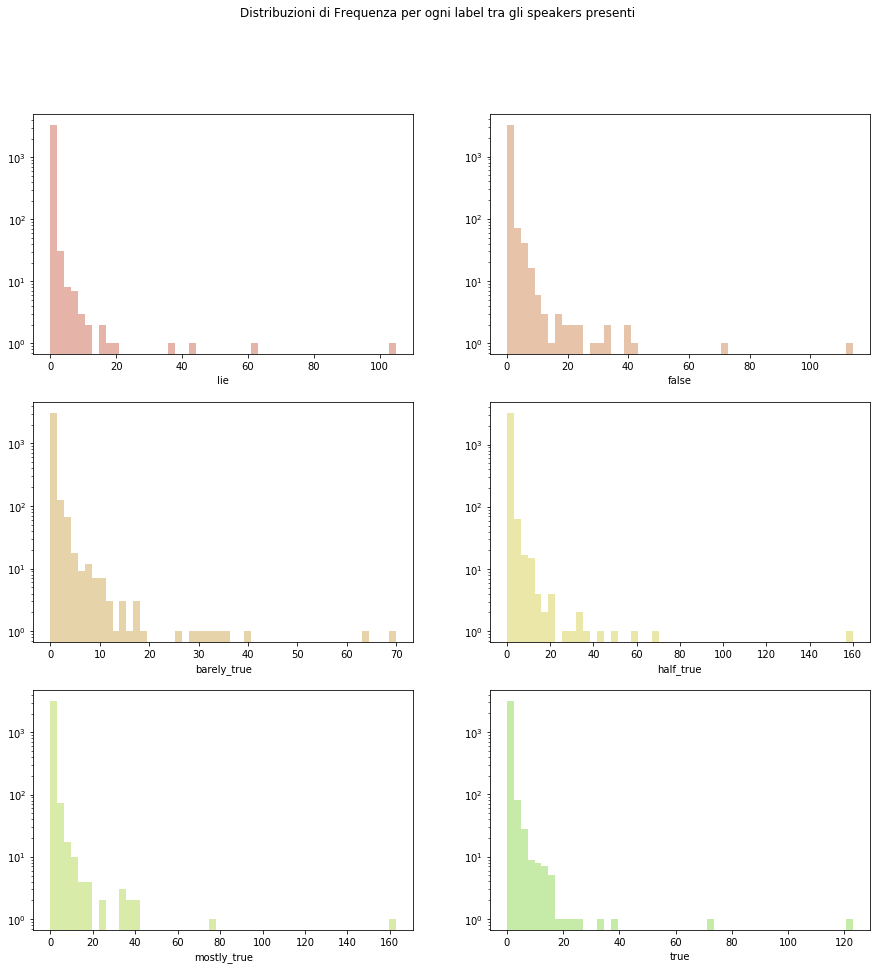

In [12]:
name = "../../plots/distplot_speakers.pdf".format("ME")
pages = PdfPages(name)

f, axes = plt.subplots(3, 2, figsize=(15, 15))
f.suptitle("Distribuzioni di Frequenza per ogni label tra gli speakers presenti")

sns.distplot(hv['lie'], hist =True, kde = False, color="#C24328", ax=axes[0, 0]).set_yscale('log')
sns.distplot(hv['false'], hist=True, kde = False, color="#C26928", ax=axes[0, 1]).set_yscale('log')
sns.distplot(hv['barely_true'], hist=True, kde = False, color="#C29328", ax=axes[1, 0]).set_yscale('log')
sns.distplot(hv['half_true'], hist=True, kde = False, color="#CDC42A", ax=axes[1, 1]).set_yscale('log')
sns.distplot(hv['mostly_true'], hist=True, kde = False, color="#A1CD2A", ax=axes[2, 0]).set_yscale('log')
sns.distplot(hv['true'], hist=True, kde = False, color="#72CD2A", ax=axes[2, 1]).set_yscale('log')

pages.savefig(bbox_inches='tight');pages.close()

In [13]:

#name = "../../plots/distplot_speakers.pdf".format("ME")
#pages = PdfPages(name)

#sns.set(style="white", palette="muted", color_codes=True)
#f, axes = plt.subplots(3, 2, figsize=(15, 15))
#sns.distplot(hv['true'], hist=True, kde = False, color="#72CD2A", ax=axes[2, 1]).set_yscale('log')
#f.suptitle("Distribuzioni di Frequenza per ogni label tra gli speakers presenti")
#sns.distplot(hv['lie'], hist =False, color="#C24328", ax=axes[0, 0]).set_xscale('log')
#sns.distplot(hv['false'], hist=False, color="#C26928", ax=axes[0, 1]).set_xscale('log')
#sns.distplot(hv['barely_true'], hist=False, color="#C29328", ax=axes[1, 0]).set_xscale('log')
#sns.distplot(hv['half_true'], hist=False, color="#CDC42A", ax=axes[1, 1]).set_xscale('log')
#sns.distplot(hv['mostly_true'], hist=False, color="#A1CD2A", ax=axes[2, 0]).set_xscale('log')
#sns.distplot(hv['true'], hist=False, color="#72CD2A", ax=axes[2, 1]).set_xscale('log')

#pages.savefig(bbox_inches='tight');pages.close()


<h5>Analisi</h5>

In [14]:
# Conteggio dei singoli party in termini di occorrenze assolute
grouby_party = df.groupby("party").count()[['id_par']]
grouby_party = grouby_party.sort_values(by = ['id_par'], ascending = False)
grouby_party

,id_par
party,
republican,5662
democrat,4137
none,2181
organization,264
independent,180
newsmaker,64
libertarian,51
journalist,49
activist,45


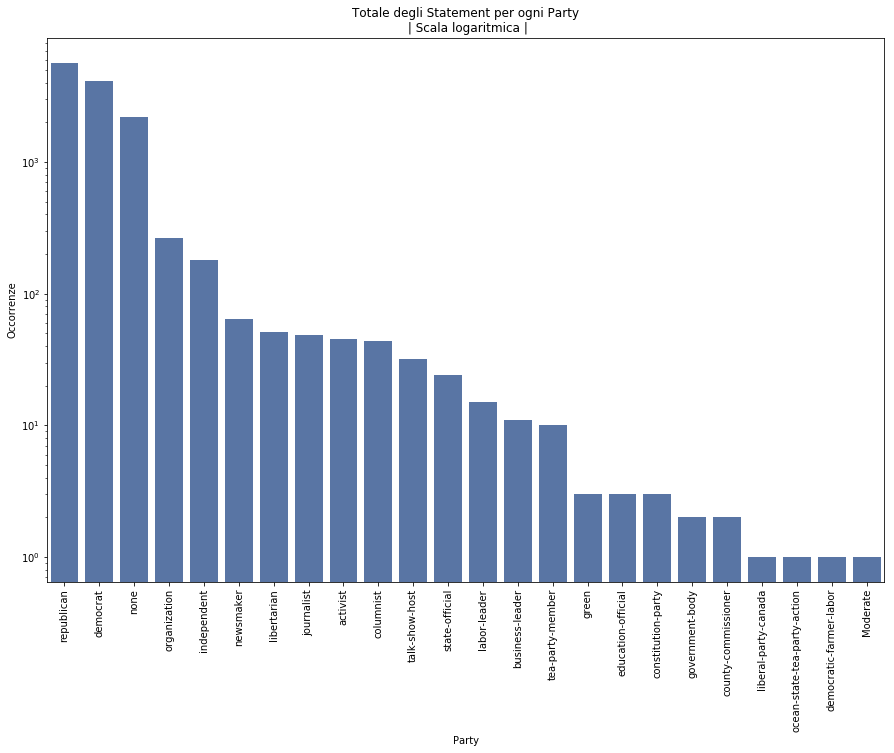

In [15]:
# Grafico dei party, log scale su y
name = "../../plots/total_statements_party.pdf".format("ME")
pages = PdfPages(name)
# Visualization
plt.figure(figsize = (15,10))
g = sns.barplot(x = grouby_party.index, y = grouby_party.id_par, color = sns.color_palette("deep", 8)[6])
plt.xticks(rotation = 90)
g.set_yscale('log')
plt.xlabel('Party')
plt.ylabel('Occorrenze')
plt.title('Totale degli Statement per ogni Party\n | Scala logaritmica |')

pages.savefig(bbox_inches='tight');pages.close()

In [16]:
# Incidenza relativa di ciascuna label all'interno dei maggiori party per numero di occorrenze
df_pl = df.groupby(["party", "label"]).count()[['id_par']]
df_pl = df_pl.unstack();
df_pl = df_pl.fillna(0)
df_pl.columns = ['barely_true', 'false', 'half_true', 'mostly_true', 'lie', 'true']
df_pl = manage_total(df_pl, 50)

horiz = summary_ratios(df_pl)
df_pl = df_pl[['lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true', 'total']]
df_pl

,lie,false,barely_true,half_true,mostly_true,true,total
party,,,,,,,
democrat,0.045,0.153,0.142,0.225,0.241,0.195,4137.0
independent,0.022,0.128,0.150,0.167,0.372,0.161,180.0
libertarian,0.078,0.137,0.118,0.255,0.235,0.176,51.0
newsmaker,0.062,0.156,0.141,0.172,0.203,0.266,64.0
none,0.161,0.193,0.151,0.180,0.173,0.142,2181.0
organization,0.080,0.223,0.212,0.265,0.110,0.110,264.0
republican,0.081,0.229,0.187,0.200,0.159,0.143,5662.0


In [17]:
# Party con maggior incidenza di una label
print_max_label(df_pl, 'lie')
print_max_label(df_pl, 'false')
print_max_label(df_pl, 'barely_true')
print_max_label(df_pl, 'half_true')
print_max_label(df_pl, 'mostly_true')
print_max_label(df_pl, 'true')

History Vector dell'elemento con maggior numero di lie in proporzione al totale di statements:
lie               0.161
false             0.193
barely_true       0.151
half_true         0.180
mostly_true       0.173
true              0.142
total          2181.000
Name: none, dtype: float64


History Vector dell'elemento con maggior numero di false in proporzione al totale di statements:
lie               0.081
false             0.229
barely_true       0.187
half_true         0.200
mostly_true       0.159
true              0.143
total          5662.000
Name: republican, dtype: float64


History Vector dell'elemento con maggior numero di barely_true in proporzione al totale di statements:
lie              0.080
false            0.223
barely_true      0.212
half_true        0.265
mostly_true      0.110
true             0.110
total          264.000
Name: organization, dtype: float64


History Vector dell'elemento con maggior numero di half_true in proporzione al totale di statements:
lie   

12539.0

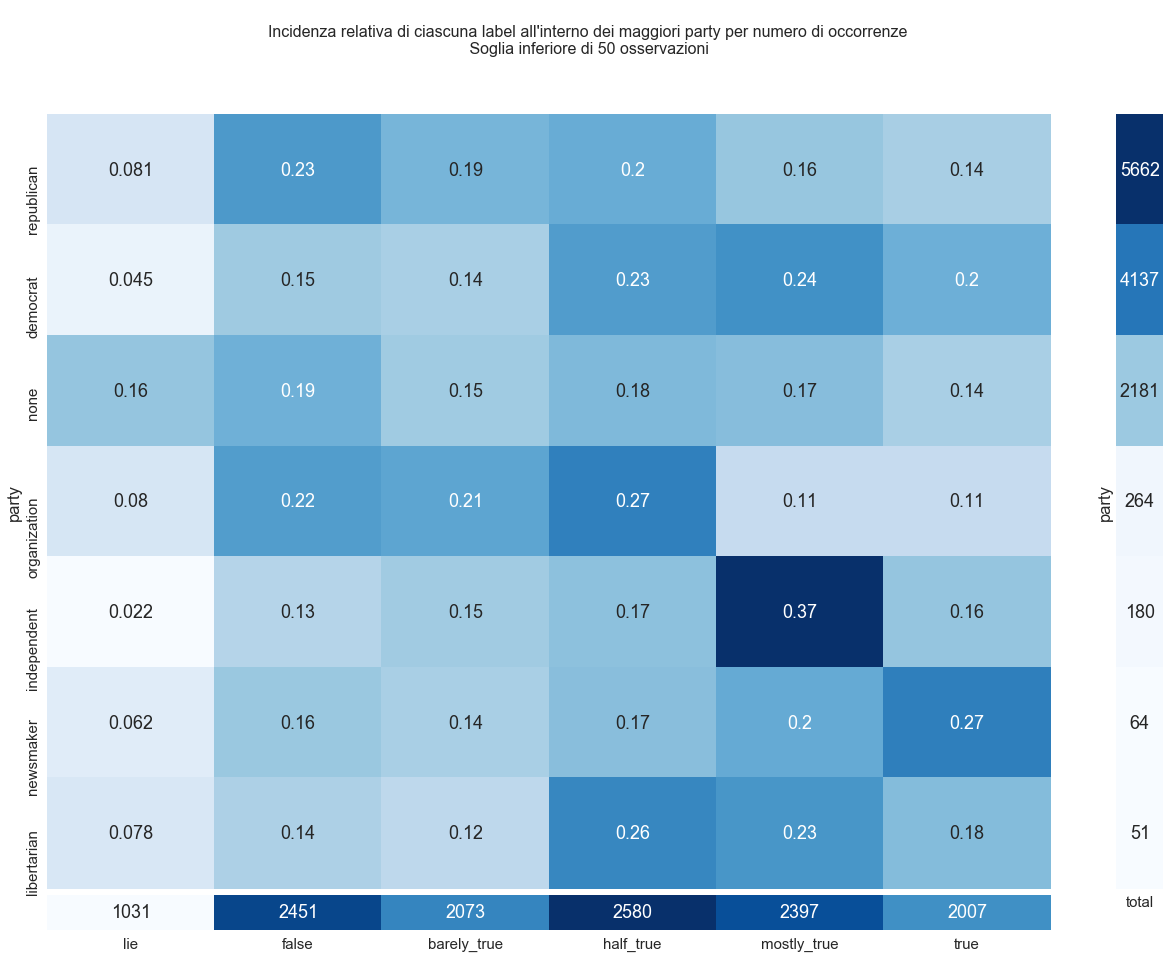

In [18]:
# Grafico incidenza labels per party
heatmap(df_pl, horiz, "\nIncidenza relativa di ciascuna label all'interno dei maggiori party per numero di occorrenze\n Soglia inferiore di 50 osservazioni\n",
       'Label', 'Party', 'label_party_heatmap')


In [19]:
# Conteggio singole etichette
groupby_label = df.groupby('label').count()[['id_par']]
# Riordino
groupby_label = groupby_label.reindex(["pants-fire", "false", "barely-true", "half-true", "mostly-true", "true"])
groupby_label

,id_par
label,
pants-fire,1047
false,2504
barely-true,2102
half-true,2627
mostly-true,2454
true,2052


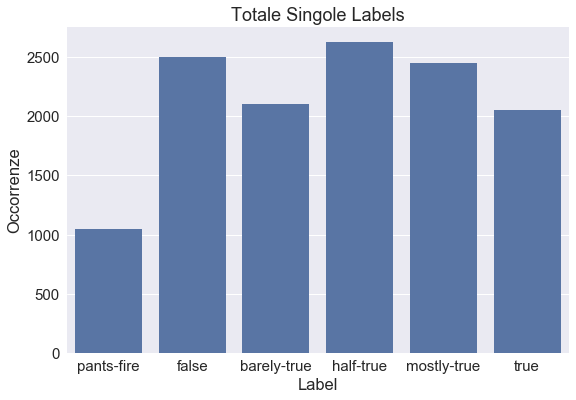

In [20]:
# Grafico per le singole etichette
name = "../../plots/total_labels.pdf".format("ME")
pages = PdfPages(name)
# visualization
plt.figure(figsize = (9,6))
sns.barplot(x = groupby_label.index, y = groupby_label.id_par, color = sns.color_palette("deep", 8)[6])
plt.xlabel('Label')
plt.ylabel('Occorrenze')
plt.title('Totale Singole Labels')

pages.savefig(bbox_inches='tight');pages.close()

In [21]:
# Occorrenze labels per i diversi party
pl = df.groupby(['party', 'label']).count()[['id_par']]

In [22]:
# Costruzione dati su Party e Labels maggioritarie
pop_pl = clean_unstack(pl)
pop_pl = manage_total(pop_pl, 10)
# Normalizzo e dis_honest
horiz = summary_ratios(pop_pl)
# Valori normalizzati in relazione al totale. Per riga
pop_pl = pop_pl[['lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true', 'total']]
pop_pl

,lie,false,barely_true,half_true,mostly_true,true,total
party,,,,,,,
activist,0.000,0.200,0.156,0.244,0.289,0.111,45.0
business-leader,0.182,0.091,0.000,0.000,0.182,0.545,11.0
columnist,0.023,0.250,0.205,0.091,0.159,0.273,44.0
democrat,0.045,0.153,0.142,0.225,0.241,0.195,4137.0
independent,0.022,0.128,0.150,0.167,0.372,0.161,180.0
journalist,0.061,0.204,0.102,0.143,0.306,0.184,49.0
labor-leader,0.067,0.200,0.200,0.200,0.200,0.133,15.0
libertarian,0.078,0.137,0.118,0.255,0.235,0.176,51.0
newsmaker,0.062,0.156,0.141,0.172,0.203,0.266,64.0


12769.0

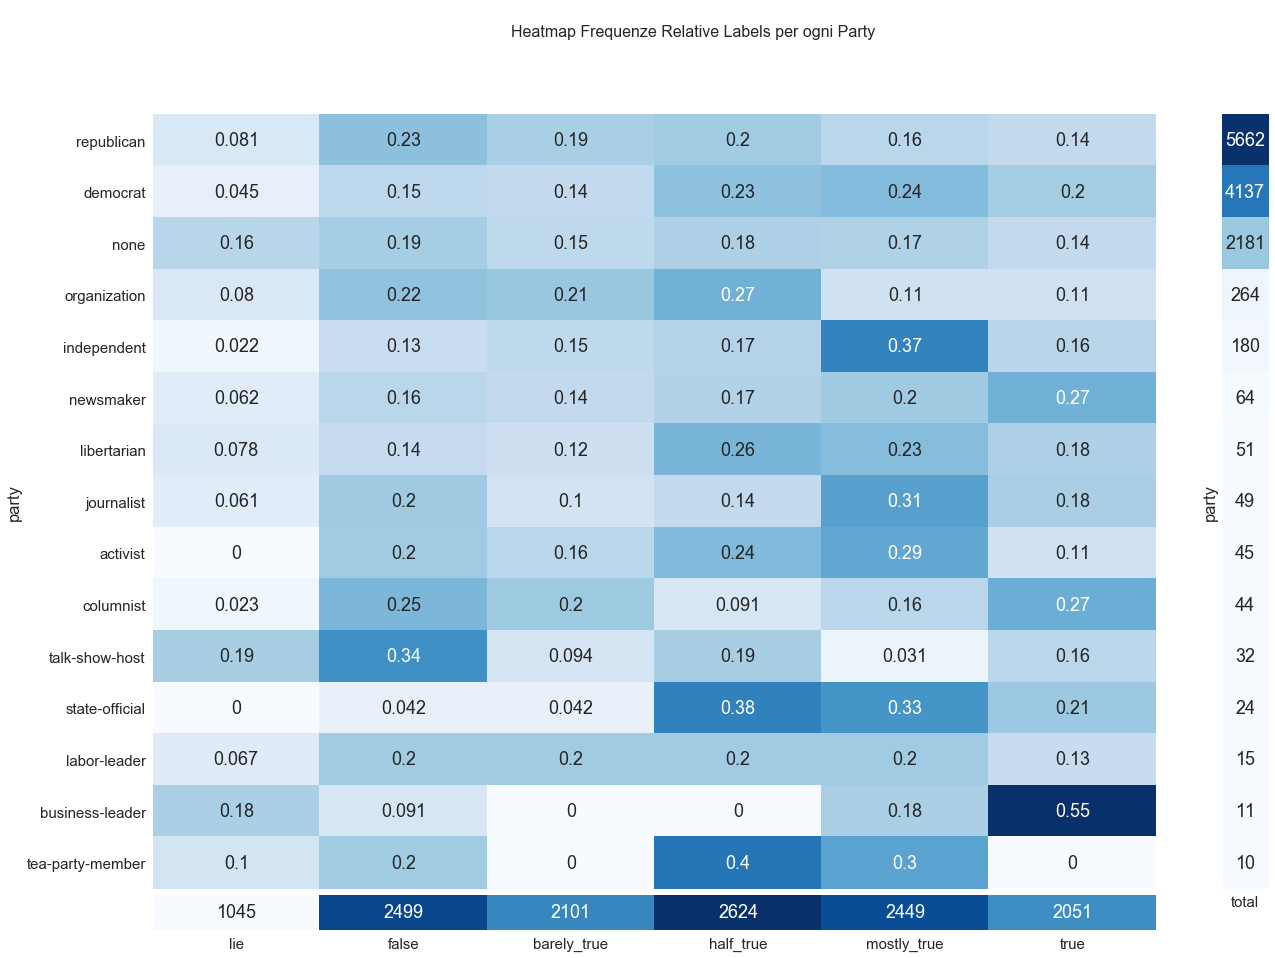

In [23]:
# Grafico Party distinti e relative labels
heatmap(pop_pl, horiz, "\nHeatmap Frequenze Relative Labels per ogni Party\n",
        'Labels', 'Party', 'more_party_label_heatmap')


In [24]:
# Subjects maggiormente frequenti
subj = df.groupby(['subject']).count()[['id_par']]
subj = subj.reset_index()
subj = subj[subj['id_par'] > 100].sort_values(by=['id_par'], ascending=False)
subj

,subject,id_par
3666,health-care,474
4487,taxes,356
2751,education,309
2892,elections,304
3946,immigration,302
557,candidates-biography,239
2351,economy,170
3207,federal-budget,152
3634,guns,152
2602,"economy,jobs",151


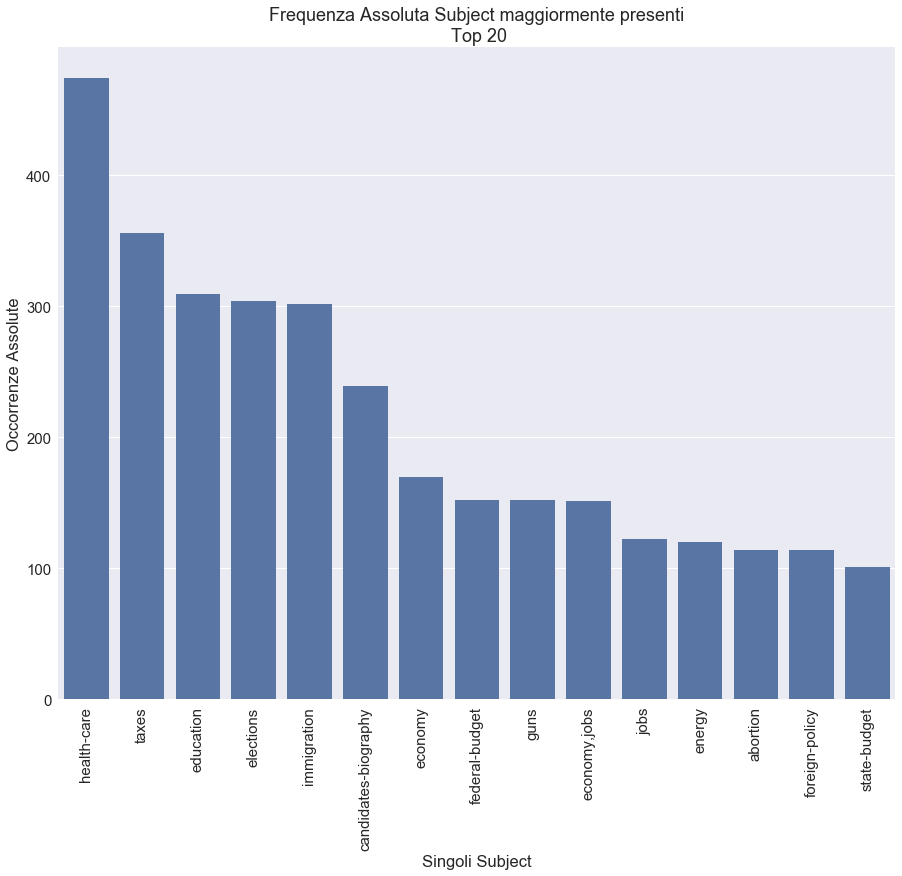

In [25]:
name = "../../plots/total_labels.pdf".format("ME")
pages = PdfPages(name)
# visualization
plt.figure(figsize=(15, 12))
sns.barplot(x = subj.head(20).subject, y = subj.head(20).id_par, 
            color = sns.color_palette("deep", 8)[6])
plt.xticks(rotation = 90)
plt.xlabel('Singoli Subject')
plt.ylabel('Occorrenze Assolute')
plt.title('Frequenza Assoluta Subject maggiormente presenti\n Top 20')

pages.savefig(bbox_inches='tight');pages.close()

In [26]:
# Frequenza relativa singole labels per ogni subject
sl = df.groupby(['subject', 'label']).count()[['id_par']]
pop_subject_labels = sl.unstack();
pop_subject_labels = pop_subject_labels.fillna(0)
pop_subject_labels.columns = ['barely_true', 'false', 'half_true', 'mostly_true', 'lie', 'true']
# Conteggio totali
pop_subject_labels['total'] = pop_subject_labels.apply(lambda row: row.barely_true + row.false + row.half_true + row.mostly_true +
                              row.lie + row.true, axis = 1)
# Elimino subject poco rappresentati
pop_subject_labels = pop_subject_labels.sort_values(by=['total'], ascending=False)

# Normalizzo e dis_honest
horiz = summary_ratios(pop_subject_labels.head(20))

pop_subject_labels = pop_subject_labels[['lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true', 'total']]

# Visualizzazione dei top 20 per numero totale di occorrenze
pop_subject_labels.head(20)


c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

,lie,false,barely_true,half_true,mostly_true,true,total
subject,,,,,,,
health-care,0.091,0.245,0.186,0.203,0.139,0.137,474.0
taxes,0.070,0.177,0.166,0.211,0.211,0.166,356.0
education,0.045,0.149,0.159,0.220,0.246,0.181,309.0
elections,0.115,0.211,0.122,0.141,0.178,0.234,304.0
immigration,0.096,0.212,0.175,0.209,0.215,0.093,302.0
candidates-biography,0.134,0.188,0.205,0.117,0.151,0.205,239.0
economy,0.018,0.171,0.153,0.241,0.182,0.235,170.0
federal-budget,0.033,0.151,0.118,0.250,0.243,0.204,152.0
guns,0.092,0.178,0.125,0.204,0.178,0.224,152.0


3579.0

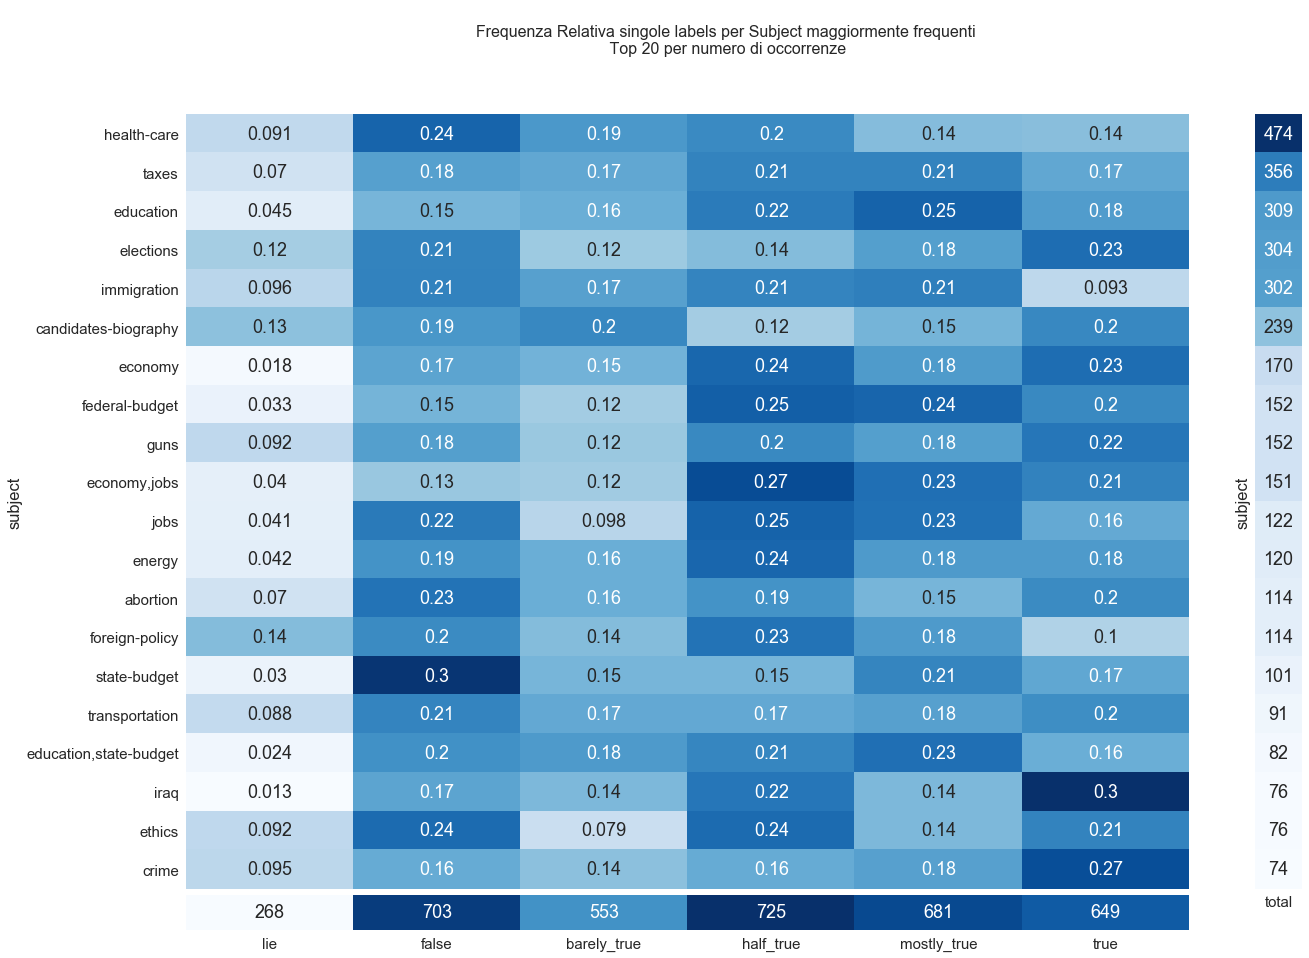

In [27]:
# Grafico
subject_heatmap1 = heatmap(pop_subject_labels.head(20), horiz,
       "\nFrequenza Relativa singole labels per Subject maggiormente frequenti\n Top 20 per numero di occorrenze\n",
       'Label', 'Party', 'heatmap_subject_labels_top20')
subject_heatmap1

In [28]:
# Subjects con label maggiormente incisive sul totale. Selezione sui top 20
print_max_label(pop_subject_labels.head(20), 'lie')
print_max_label(pop_subject_labels.head(20), 'false')
print_max_label(pop_subject_labels.head(20), 'barely_true')
print_max_label(pop_subject_labels.head(20), 'half_true')
print_max_label(pop_subject_labels.head(20), 'mostly_true')
print_max_label(pop_subject_labels.head(20), 'true')

History Vector dell'elemento con maggior numero di lie in proporzione al totale di statements:
lie              0.140
false            0.202
barely_true      0.140
half_true        0.228
mostly_true      0.184
true             0.105
total          114.000
Name: foreign-policy, dtype: float64


History Vector dell'elemento con maggior numero di false in proporzione al totale di statements:
lie              0.030
false            0.297
barely_true      0.149
half_true        0.149
mostly_true      0.208
true             0.168
total          101.000
Name: state-budget, dtype: float64


History Vector dell'elemento con maggior numero di barely_true in proporzione al totale di statements:
lie              0.134
false            0.188
barely_true      0.205
half_true        0.117
mostly_true      0.151
true             0.205
total          239.000
Name: candidates-biography, dtype: float64


History Vector dell'elemento con maggior numero di half_true in proporzione al totale di statements:


In [29]:
# Cosa cambia se divido i subject multipli in singoli e ne riconto le occorrenze?
# Split dei singoli subject
df_sl = df.groupby(['subject', 'label']).count()[['id_par']]
df_sl = df_sl.unstack()
df_sl = df_sl.fillna(0)
df_sl.columns = ['barely_true', 'false', 'half_true', 'mostly_true', 'lie', 'true']
df_sl = df_sl.reset_index()
# Ritorno una lista di elementi prima separati dalla virgola
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# Calcolo la lunghezza degli split
lens = df_sl['subject'].str.split(',').map(len)

# Creo un nuovo dataframe, ripetendo o concatenando a seconda del caso
res = pd.DataFrame({'subject': chainer(df_sl['subject']),
                    'barely_true': np.repeat(df_sl['barely_true'], lens),
                    'false': np.repeat(df_sl['false'], lens),
                    'half_true': np.repeat(df_sl['half_true'], lens),
                    'mostly_true': np.repeat(df_sl['mostly_true'], lens),
                    'lie': np.repeat(df_sl['lie'], lens),
                    'true': np.repeat(df_sl['true'], lens),
                   })
# Riarrangio
res = res[['subject', 'lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true']]
# Ora raggruppo per subject singoli
df_res = res.groupby('subject').sum()[['lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true']]
df_res.head()


,lie,false,barely_true,half_true,mostly_true,true
subject,,,,,,
10-news-tampa-bay,1.0,1.0,2.0,1.0,1.0,0.0
Alcohol,1.0,9.0,8.0,4.0,8.0,10.0
abc-news-week,1.0,22.0,13.0,30.0,31.0,22.0
abortion,27.0,64.0,55.0,65.0,47.0,54.0
afghanistan,5.0,12.0,4.0,9.0,13.0,17.0


In [30]:
# Subjects maggiormente frequenti
df_tot_res = res.groupby(['subject']).count()
df_tot_res = df_tot_res.reset_index()
df_tot_res = df_tot_res[['subject', 'lie']]
df_tot_res.columns = ['subject', 'total']
df_tot_res = df_tot_res.sort_values(by=['total'], ascending=False)

df_tot_res.head(20)


,subject,total
42,economy,662
64,health-care,477
127,taxes,450
50,federal-budget,430
122,state-budget,375
78,jobs,367
15,candidates-biography,355
32,crime,303
65,history,301
43,education,300


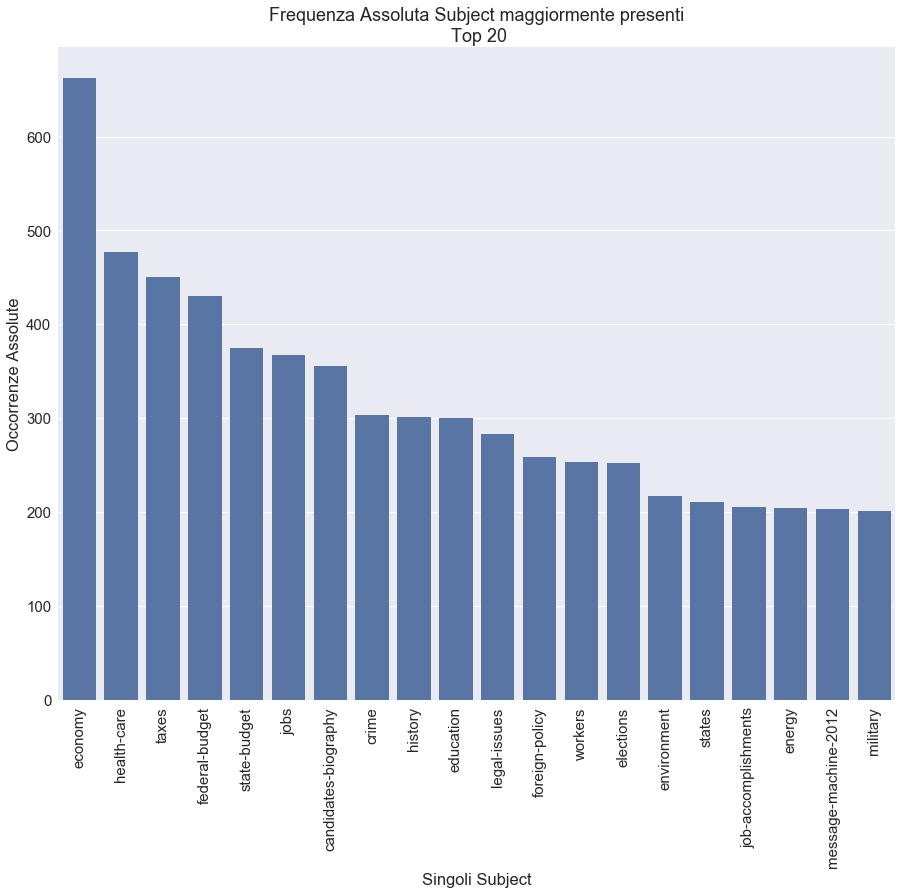

In [31]:
# Nuovo grafico per numero di occorrenze totali sui subject | su dataframe splittato
name = "../../plots/total_labels_splitted.pdf".format("ME")
pages = PdfPages(name)
# visualization
plt.figure(figsize=(15, 12))
sns.barplot(x = df_tot_res.head(20).subject, y = df_tot_res.head(20).total, 
            color = sns.color_palette("deep", 8)[6])
plt.xticks(rotation = 90)
plt.xlabel('Singoli Subject')
plt.ylabel('Occorrenze Assolute')
plt.title('Frequenza Assoluta Subject maggiormente presenti\n Top 20')

pages.savefig(bbox_inches='tight');pages.close()

In [32]:
# Calcolo frequenze relative label su nuovi subject
df_res['total'] = df_res.apply(lambda row: row.barely_true + row.false + row.half_true + row.mostly_true +
                              row.lie + row.true, axis = 1)
df_res = df_res.sort_values(by=['total'], ascending=False)
# Normalizzo
horiz = summary_ratios(df_res.head(20))
df_res.head(20)

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

,lie,false,barely_true,half_true,mostly_true,true,total
subject,,,,,,,
economy,0.051,0.167,0.152,0.240,0.213,0.176,1431.0
health-care,0.105,0.232,0.201,0.196,0.150,0.116,1426.0
taxes,0.068,0.189,0.184,0.210,0.217,0.132,1218.0
federal-budget,0.046,0.195,0.170,0.236,0.191,0.162,937.0
education,0.052,0.159,0.168,0.243,0.225,0.153,926.0
jobs,0.050,0.183,0.166,0.265,0.183,0.154,898.0
state-budget,0.064,0.192,0.168,0.207,0.217,0.151,879.0
candidates-biography,0.118,0.206,0.171,0.176,0.181,0.147,805.0
elections,0.099,0.227,0.115,0.166,0.202,0.190,757.0


14435.0

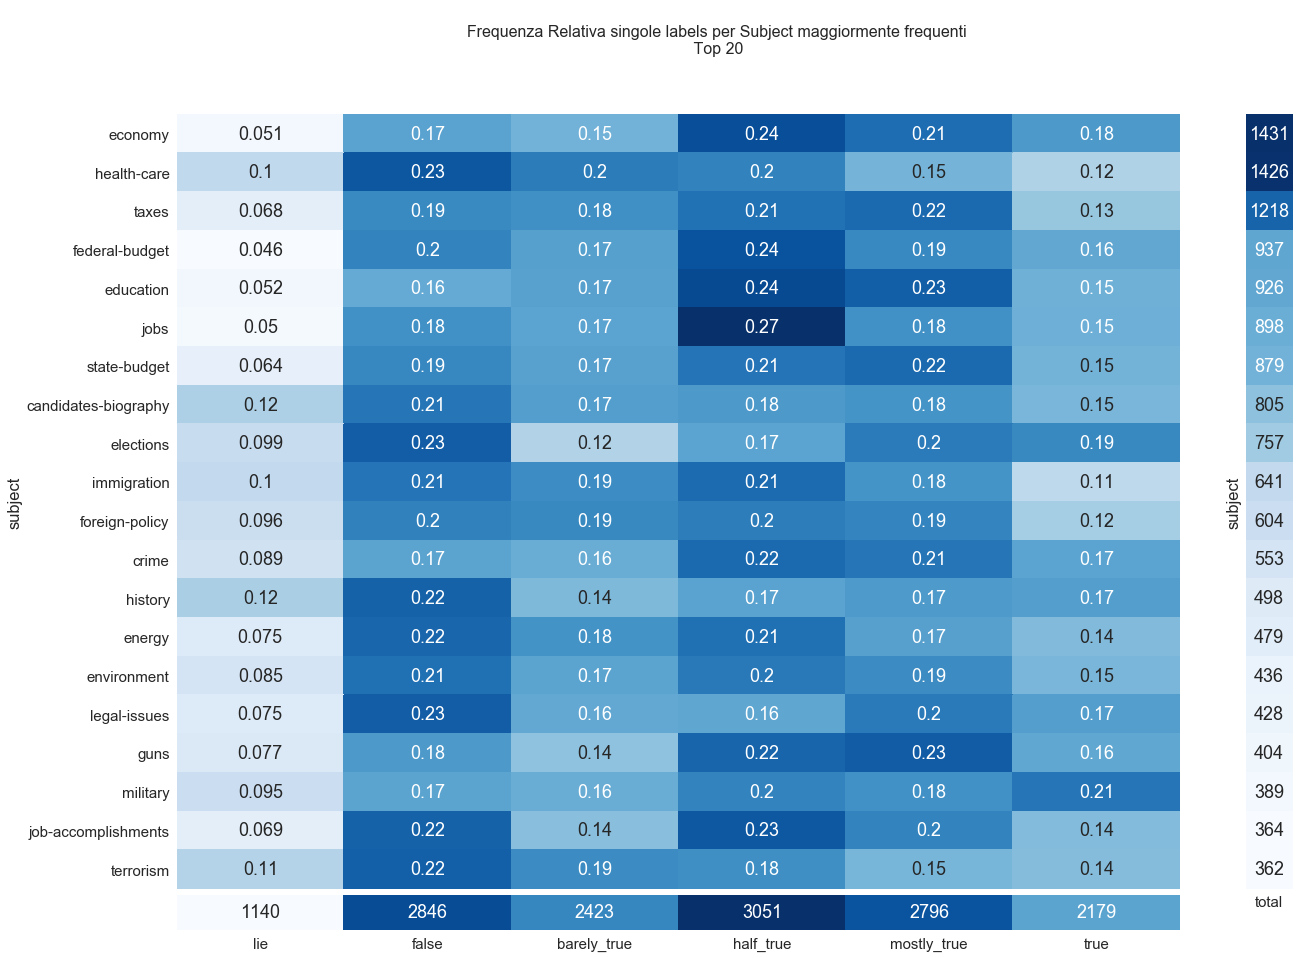

In [33]:
# Grafico
subject_heatmap2 = heatmap(df_res.head(20), horiz, "\nFrequenza Relativa singole labels per Subject maggiormente frequenti\n Top 20\n",
       'Label', 'Subject', 'heatmap_subject_labels_top20_split')

subject_heatmap2

In [34]:
# Subjects con label maggiormente incisive sul totale
print_max_label(df_res.head(20), 'lie')
print_max_label(df_res.head(20), 'false')
print_max_label(df_res.head(20), 'barely_true')
print_max_label(df_res.head(20), 'half_true')
print_max_label(df_res.head(20), 'mostly_true')
print_max_label(df_res.head(20), 'true')

History Vector dell'elemento con maggior numero di lie in proporzione al totale di statements:
lie              0.120
false            0.223
barely_true      0.145
half_true        0.167
mostly_true      0.175
true             0.171
total          498.000
Name: history, dtype: float64


History Vector dell'elemento con maggior numero di false in proporzione al totale di statements:
lie               0.105
false             0.232
barely_true       0.201
half_true         0.196
mostly_true       0.150
true              0.116
total          1426.000
Name: health-care, dtype: float64


History Vector dell'elemento con maggior numero di barely_true in proporzione al totale di statements:
lie               0.105
false             0.232
barely_true       0.201
half_true         0.196
mostly_true       0.150
true              0.116
total          1426.000
Name: health-care, dtype: float64


History Vector dell'elemento con maggior numero di half_true in proporzione al totale di statements:
lie

In [35]:
df_sl = df.groupby(['subject', 'label']).count()[['id_par']]
df_sl = df_sl.unstack()
df_sl = df_sl.fillna(0)
df_sl.columns = ['barely_true', 'false', 'half_true', 'mostly_true', 'lie', 'true']
df_sl = df_sl.reset_index()
# Ritorno una lista di elementi prima separati dalla virgola
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# Calcolo la lunghezza degli split
lens = df_sl['subject'].str.split(',').map(len)
# Creo un nuovo dataframe, ripetendo o concatenando a seconda del caso

res_fraction = pd.DataFrame({'subject': chainer(df_sl['subject']),
                    'barely_true': np.repeat(round(df_sl['barely_true']/lens,3), lens),
                    'false': np.repeat(round(df_sl['false']/lens,3), lens),
                    'half_true': np.repeat(round(df_sl['half_true']/lens,3), lens),
                    'mostly_true': np.repeat(round(df_sl['mostly_true']/lens,3), lens),
                    'lie': np.repeat(round(df_sl['lie']/lens,3), lens),
                    'true': np.repeat(round(df_sl['true']/lens,3), lens),
                   })
# Riarrangio
res_fraction = res_fraction[['subject', 'lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true']]
# Ovviamente il conteggio totale dei subject è uguale
res_fraction = res_fraction.groupby('subject').sum()[['lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true']]

res_fraction.head(20)

,lie,false,barely_true,half_true,mostly_true,true
subject,,,,,,
10-news-tampa-bay,0.250,0.333,0.400,0.333,0.500,0.000
Alcohol,0.333,3.866,3.583,2.333,3.233,4.949
abc-news-week,0.333,8.148,4.099,10.742,9.898,7.491
abortion,15.081,40.957,32.297,38.975,27.460,35.409
afghanistan,1.916,3.716,3.500,2.782,6.734,4.998
after-the-fact,0.000,0.250,0.000,0.000,0.000,0.200
agriculture,2.333,5.782,6.532,7.543,3.957,6.792
animals,5.416,3.833,1.333,4.559,4.969,3.025
autism,0.000,1.333,0.000,0.000,0.000,0.125


In [36]:
# Calcolo frequenze relative label su nuovi subject
res_fraction['total'] = res_fraction.apply(lambda row: row.barely_true + row.false + row.half_true + row.mostly_true +
                              row.lie + row.true, axis = 1)
res_fraction = res_fraction.sort_values(by=['total'], ascending=False)
tot = res_fraction['total'].sum()
display (tot)
# Normalizzo
horiz = summary_ratios(res_fraction.head(20))
res_fraction.head(20)


12784.616999999998

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

,lie,false,barely_true,half_true,mostly_true,true,total
subject,,,,,,,
health-care,0.102,0.235,0.195,0.199,0.144,0.125,835.219
taxes,0.069,0.184,0.182,0.205,0.214,0.146,671.317
economy,0.043,0.163,0.146,0.242,0.214,0.191,611.255
education,0.048,0.153,0.168,0.233,0.231,0.167,548.263
elections,0.107,0.221,0.118,0.156,0.190,0.209,484.996
candidates-biography,0.125,0.201,0.183,0.158,0.166,0.167,447.016
immigration,0.101,0.213,0.181,0.210,0.197,0.098,436.484
federal-budget,0.042,0.180,0.161,0.236,0.204,0.178,433.960
jobs,0.046,0.187,0.148,0.262,0.197,0.160,402.670


7410.977999999999

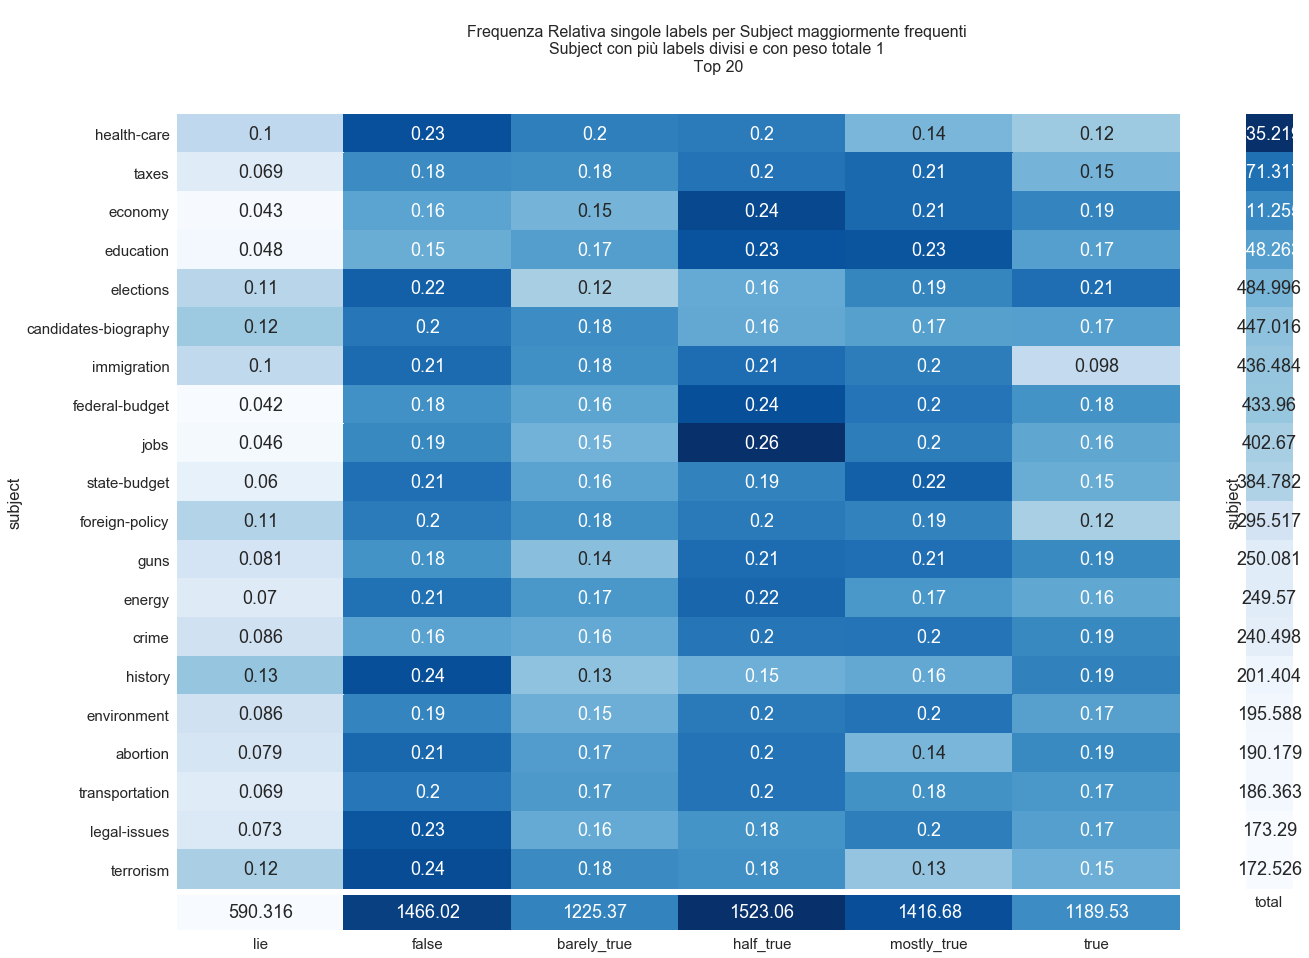

In [37]:
subject_heatmap3 = heatmap(res_fraction.head(20), horiz, "\nFrequenza Relativa singole labels per Subject maggiormente frequenti\nSubject con più labels divisi e con peso totale 1\n Top 20\n",
       'Label', 'Subject', 'heatmap_subject_labels_top20_split_percentage')
subject_heatmap3

In [38]:
# Subjects con label maggiormente incisive sul totale
print_max_label(res_fraction.head(20), 'lie')
print_max_label(res_fraction.head(20), 'false')
print_max_label(res_fraction.head(20), 'barely_true')
print_max_label(res_fraction.head(20), 'half_true')
print_max_label(res_fraction.head(20), 'mostly_true')
print_max_label(res_fraction.head(20), 'true')

History Vector dell'elemento con maggior numero di lie in proporzione al totale di statements:
lie              0.129
false            0.236
barely_true      0.133
half_true        0.151
mostly_true      0.158
true             0.194
total          201.404
Name: history, dtype: float64


History Vector dell'elemento con maggior numero di false in proporzione al totale di statements:
lie              0.116
false            0.238
barely_true      0.185
half_true        0.181
mostly_true      0.130
true             0.151
total          172.526
Name: terrorism, dtype: float64


History Vector dell'elemento con maggior numero di barely_true in proporzione al totale di statements:
lie              0.102
false            0.235
barely_true      0.195
half_true        0.199
mostly_true      0.144
true             0.125
total          835.219
Name: health-care, dtype: float64


History Vector dell'elemento con maggior numero di half_true in proporzione al totale di statements:
lie              0.

In [39]:
# La label varia a seconda del contesto? 
cl = df.groupby(['context', 'label']).count()[['id_par']]
# cl
# Troppi contesti, secondo me non sensato

In [40]:
# Maggiori speakers
speakers = df.groupby(['speaker']).count()[['id_par']]
speakers[speakers['id_par'] > 50].sort_values(by = ['id_par'], ascending = False)

,id_par
speaker,
barack-obama,611
donald-trump,343
hillary-clinton,297
mitt-romney,212
john-mccain,189
scott-walker,183
chain-email,178
rick-perry,172
marco-rubio,153


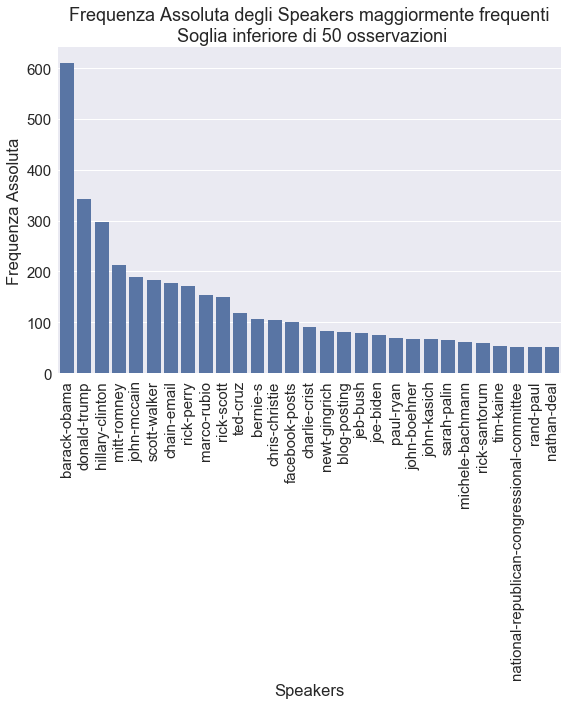

In [41]:
name = "../../plots/major_speakers.pdf".format("ME")
pages = PdfPages(name)
# visualization
plt.figure(figsize=(9,6))
sns.barplot(x=speakers[speakers['id_par'] > 50].sort_values(by = ['id_par'], ascending = False).index,
            y=speakers[speakers['id_par'] > 50].sort_values(by = ['id_par'], ascending = False).id_par, 
            color = sns.color_palette("deep", 8)[6])
plt.xticks(rotation= 90)
plt.xlabel('Speakers')
plt.ylabel('Frequenza Assoluta')
plt.title('Frequenza Assoluta degli Speakers maggiormente frequenti\n Soglia inferiore di 50 osservazioni')
pages.savefig(bbox_inches='tight');pages.close()

In [42]:
# Speakers maggiori e presenza singole labels sul loro totale
df_sl = df.groupby(['speaker', 'label']).count()[['id_par']]
df_sl = df_sl.unstack();
df_sl = df_sl.fillna(0)
df_sl.columns = ['barely_true', 'false', 'half_true', 'mostly_true', 'lie', 'true']
df_sl_norm = df_sl
df_sl_norm = manage_total(df_sl_norm, 100)
horiz = summary_ratios(df_sl_norm)
df_sl_norm = df_sl_norm[['lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true', 'total']]
df_sl_norm

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

,lie,false,barely_true,half_true,mostly_true,true,total
speaker,,,,,,,
barack-obama,0.015,0.133,0.115,0.270,0.267,0.201,611.0
bernie-s,0.000,0.113,0.170,0.198,0.387,0.132,106.0
chain-email,0.590,0.242,0.062,0.045,0.028,0.034,178.0
chris-christie,0.077,0.173,0.096,0.260,0.183,0.212,104.0
donald-trump,0.178,0.341,0.184,0.149,0.108,0.041,343.0
facebook-posts,0.360,0.180,0.140,0.150,0.110,0.060,100.0
hillary-clinton,0.024,0.108,0.135,0.232,0.256,0.246,297.0
john-mccain,0.042,0.217,0.169,0.169,0.196,0.206,189.0
marco-rubio,0.033,0.170,0.216,0.229,0.229,0.124,153.0


In [43]:
# Speaker con valore maggiore per ciascuna label in relazione al numero di statements totali per lo speaker
print_max_label(df_sl_norm, 'lie')
print_max_label(df_sl_norm, 'false')
print_max_label(df_sl_norm, 'barely_true')
print_max_label(df_sl_norm, 'half_true')
print_max_label(df_sl_norm, 'mostly_true')
print_max_label(df_sl_norm, 'true')

History Vector dell'elemento con maggior numero di lie in proporzione al totale di statements:
lie              0.590
false            0.242
barely_true      0.062
half_true        0.045
mostly_true      0.028
true             0.034
total          178.000
Name: chain-email, dtype: float64


History Vector dell'elemento con maggior numero di false in proporzione al totale di statements:
lie              0.178
false            0.341
barely_true      0.184
half_true        0.149
mostly_true      0.108
true             0.041
total          343.000
Name: donald-trump, dtype: float64


History Vector dell'elemento con maggior numero di barely_true in proporzione al totale di statements:
lie              0.068
false            0.288
barely_true      0.297
half_true        0.127
mostly_true      0.161
true             0.059
total          118.000
Name: ted-cruz, dtype: float64


History Vector dell'elemento con maggior numero di half_true in proporzione al totale di statements:
lie            

2916.0

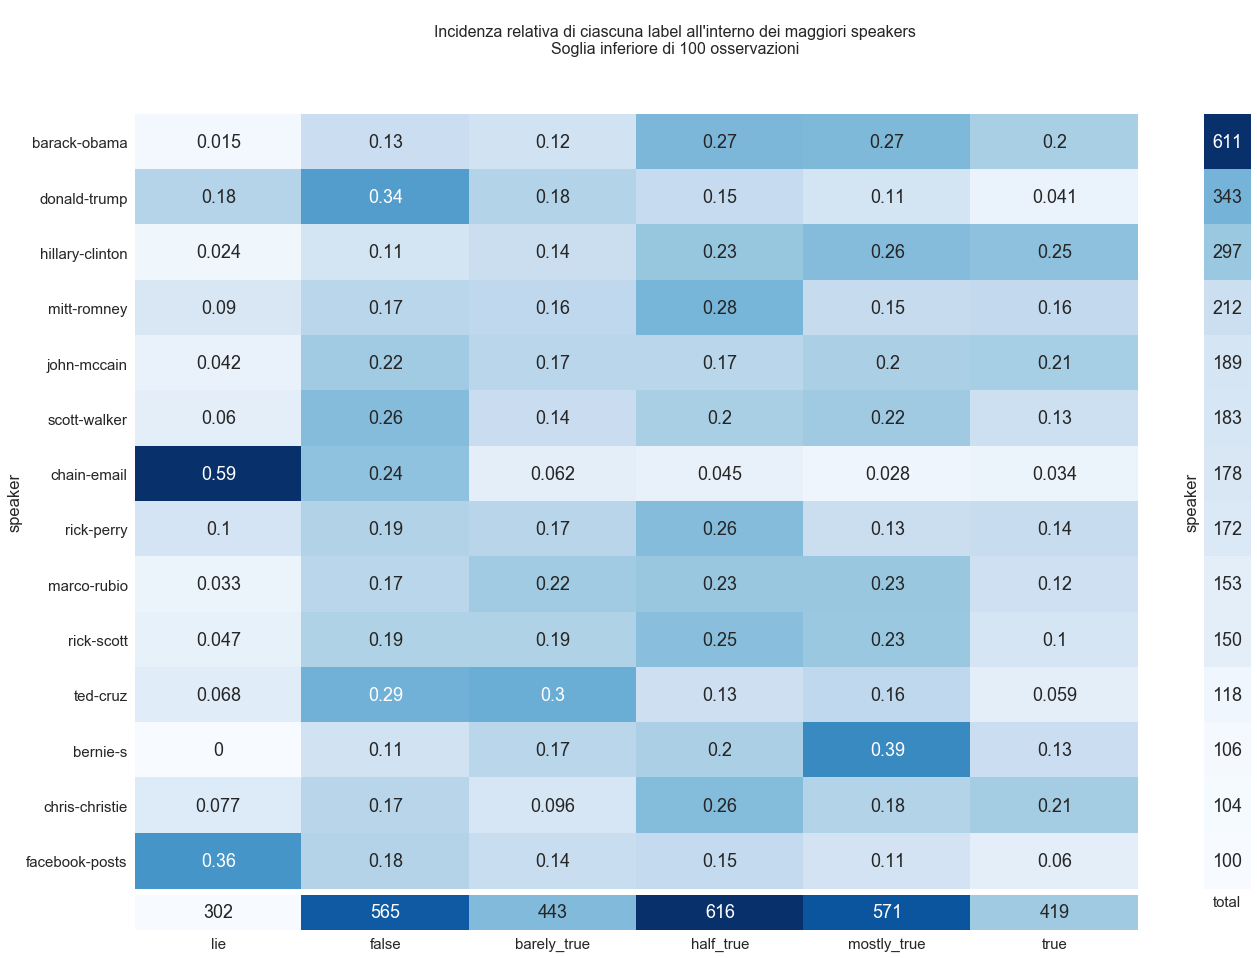

In [44]:
# Grafico
heatmap(df_sl_norm, horiz,
        "\nIncidenza relativa di ciascuna label all'interno dei maggiori speakers\nSoglia inferiore di 100 osservazioni\n",
        'Label', 'Speaker', 'heatmap_speaker_labels')

<h5>Distribuzione di frequenza delle labels tra i maggiori speakers</h5>

In [45]:
df_sl.columns = ['barely_true', 'false', 'half_true', 'mostly_true', 'lie', 'true', 'total']
df_sl = df_sl.sort_values(by = ['total'], ascending=False)
df_sl_top20 = df_sl.head(20)
df_sl_top20 = df_sl_top20[['lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true', 'total']]
df_sl_top20

,lie,false,barely_true,half_true,mostly_true,true,total
speaker,,,,,,,
barack-obama,9.0,81.0,70.0,165.0,163.0,123.0,611.0
donald-trump,61.0,117.0,63.0,51.0,37.0,14.0,343.0
hillary-clinton,7.0,32.0,40.0,69.0,76.0,73.0,297.0
mitt-romney,19.0,36.0,34.0,59.0,31.0,33.0,212.0
john-mccain,8.0,41.0,32.0,32.0,37.0,39.0,189.0
scott-walker,11.0,47.0,25.0,37.0,40.0,23.0,183.0
chain-email,105.0,43.0,11.0,8.0,5.0,6.0,178.0
rick-perry,18.0,32.0,30.0,44.0,23.0,25.0,172.0
marco-rubio,5.0,26.0,33.0,35.0,35.0,19.0,153.0


In [46]:
# Affidabilità dei maggiori speakers per i rispettivi party
psl = df.groupby(['party', 'speaker', 'label']).count()[['id_par']]

pop_psl = clean_unstack(psl)
pop_psl = manage_total(pop_psl, 50)
# Normalizzo e dis_honest
horiz = summary_ratios(pop_psl)

pop_psl = pop_psl[['lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true', 'total']]
pop_psl

lie  false  \
party       speaker                                                     
democrat    barack-obama                                 0.015  0.133   
            charlie-crist                                0.022  0.167   
            hillary-clinton                              0.024  0.108   
            joe-biden                                    0.053  0.145   
            tim-kaine                                    0.000  0.074   
independent bernie-s                                     0.000  0.113   
none        blog-posting                                 0.543  0.235   
            chain-email                                  0.590  0.242   
            facebook-posts                               0.360  0.180   
republican  chris-christie                               0.077  0.173   
            donald-trump                                 0.178  0.341   
            jeb-bush                                     0.025  0.063   
            john-boehner                                 0.029  0.324   
            john-kasich                                  0.045  0.119   
            john-mccain                                  0.042  0.217   
            marco-rubio                                  0.033  0.170   
            michele-bachmann                             0.262  0.361   
            mitt-romney                                  0.090  0.170   
            nathan-deal                                  0.000  0.115   
            national-republican-congressional-committee  0.154  0.173   
            newt-gingrich                                0.133  0.217   
            paul-ryan                                    0.029  0.100   
            rand-paul                                    0.058  0.154   
            rick-perry                                   0.105  0.186   
            rick-santorum                                0.085  0.271   
            rick-scott                                   0.047  0.187   
            sarah-palin                                  0.091  0.333   
            scott-walker                                 0.060  0.257   
            ted-cruz                                     0.068  0.288   

                                                         barely_true  \
party       speaker                                                    
democrat    barack-obama                                       0.115   
            charlie-crist                                      0.167   
            hillary-clinton                                    0.135   
            joe-biden                                          0.145   
            tim-kaine                                          0.148   
independent bernie-s                                           0.170   
none        blog-posting                                       0.086   
            chain-email                                        0.062   
            facebook-posts                                     0.140   
republican  chris-christie                                     0.096   
            donald-trump                                       0.184   
            jeb-bush                                           0.215   
            john-boehner                                       0.191   
            john-kasich                                        0.134   
            john-mccain                                        0.169   
            marco-rubio                                        0.216   
            michele-bachmann                                   0.131   
            mitt-romney                                        0.160   
            nathan-deal                                        0.173   
            national-republican-congressional-committee        0.346   
            newt-gingrich                                      0.193   
            paul-ryan                                          0.271   
            rand-paul                                          0.13

3926.0

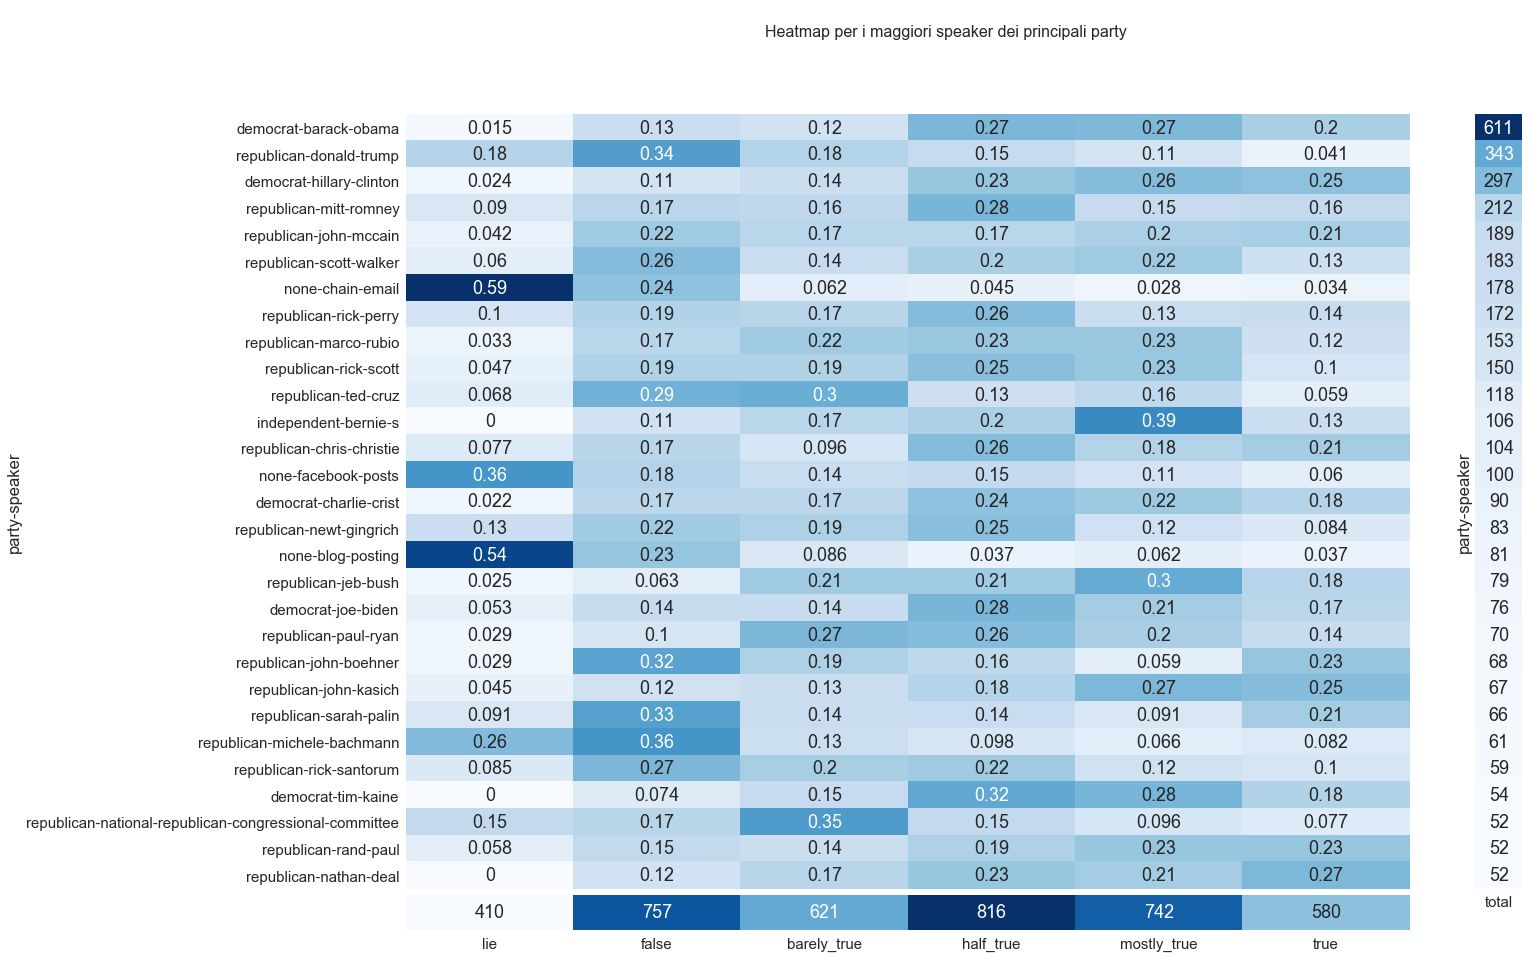

In [47]:
# Grafico
heatmap(pop_psl, horiz, "\nHeatmap per i maggiori speaker dei principali party",
       'Label', 'Party|Speaker', 'heatmap_spekerparty_label')

In [48]:
#Lunghezza frasi per ogni label
df['statement_len'] = df.apply(lambda row: len(row.statement.split()), axis = 1)

avg_len_df = df.groupby(['label']).mean()[['statement_len']]
avg_len_df

,statement_len
label,
barely-true,18.155090
false,16.835064
half-true,18.958508
mostly-true,18.504482
pants-fire,17.242598
true,18.034600


In [49]:
#Lunghezza frasi per ogni label sui partiti
df['statement_len'] = df.apply(lambda row: len(row.statement.split()), axis = 1)
avg_len_df_pl = df.groupby(['party', 'label']).mean()[['statement_len']]
# Considero solo i party maggiormente rappresentati
avg_len_df_pl = avg_len_df_pl.loc[['democrat', 'republican', 'none']]
avg_len_df_pl

statement_len
party      label                     
democrat   barely-true      18.160410
           false            16.456556
           half-true        19.018260
           mostly-true      19.126633
           pants-fire       16.935135
           true             18.456010
none       barely-true      18.094225
           false            17.223278
           half-true        19.418367
           mostly-true      17.690476
           pants-fire       17.906250
           true             17.954693
republican barely-true      18.261321
           false            16.879815
           half-true        18.662842
           mostly-true      18.241417
           pants-fire       16.878525
           true             17.460967

Text(0.5,0,'Party')

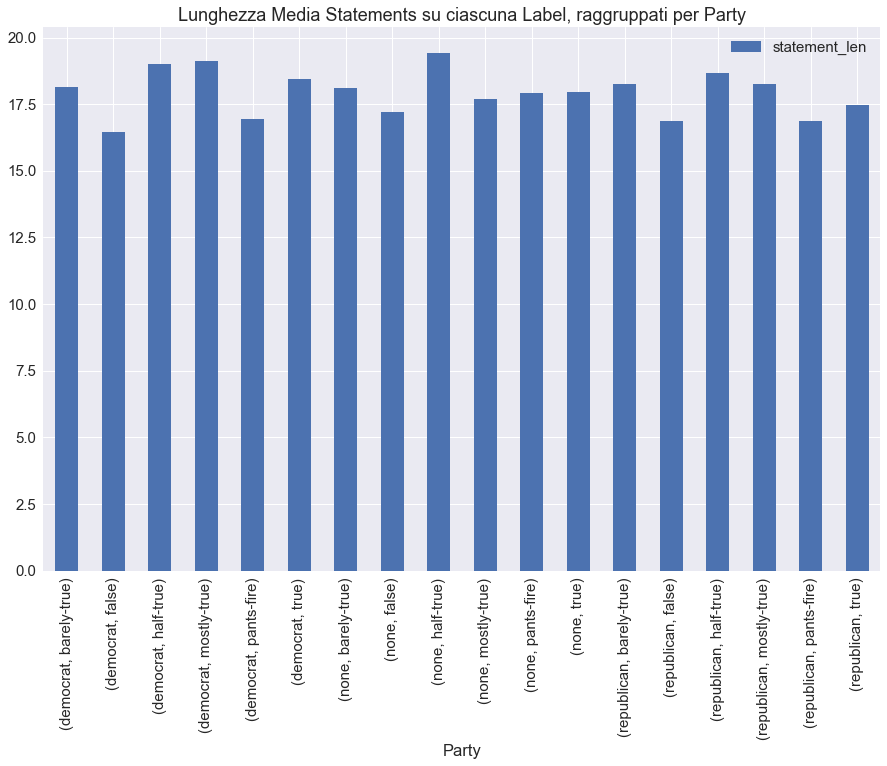

In [50]:
#name = "../../plots/statement_lenByParty.pdf".format("ME")
#pages = PdfPages(name)

# Grafico
avg_len_df_pl.plot(kind = 'bar', figsize=(15,10), color = sns.color_palette("deep", 8)[6])
plt.title("Lunghezza Media Statements su ciascuna Label, raggruppati per Party" )
plt.xlabel("Party")

#pages.savefig(bbox_inches='tight');pages.close()



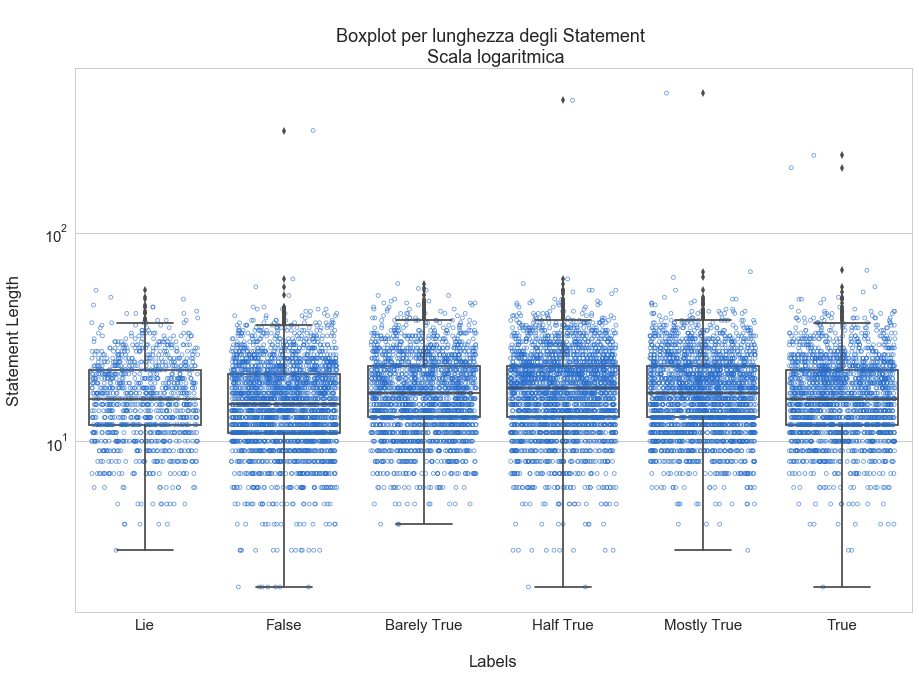

In [51]:
# Lunghezza di ogni statement
df['statement_len'] = df.apply(lambda row: len(row.statement.split()), axis = 1)
ddf = df[['id_par', 'label', 'statement_len']]
# Grafico
name = "../../plots/sLen_total.pdf".format("ME")
pages = PdfPages(name)

sns.set_style("whitegrid")


ddf = ddf.replace('pants-fire', 0).replace('false', 1).replace('barely-true', 2).replace('half-true', 3).replace('mostly-true', 4).replace('true', 5)
m = {"s": 15, "alpha": .7, 'linewidths': .8, "facecolor": 'none', 'edgecolor': '#2A6FCD'}

plt.figure(figsize=(15, 10))
ax = sns.regplot(x = 'label', y = 'statement_len', data = ddf, fit_reg = False, 
                 x_jitter = .38, scatter_kws = m)
sns.boxplot( x = 'label', y = "statement_len", data = ddf, boxprops = dict(facecolor = '#FFFFFF', alpha=1, zorder = 0))
ax.set(yscale = 'log')
ax.set_title("\nBoxplot per lunghezza degli Statement \n Scala logaritmica") 
ax.set(xlabel = '\nLabels\n', ylabel = 'Statement Length\n')
ax.set_xticklabels(['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True'])

pages.savefig(bbox_inches='tight');pages.close()

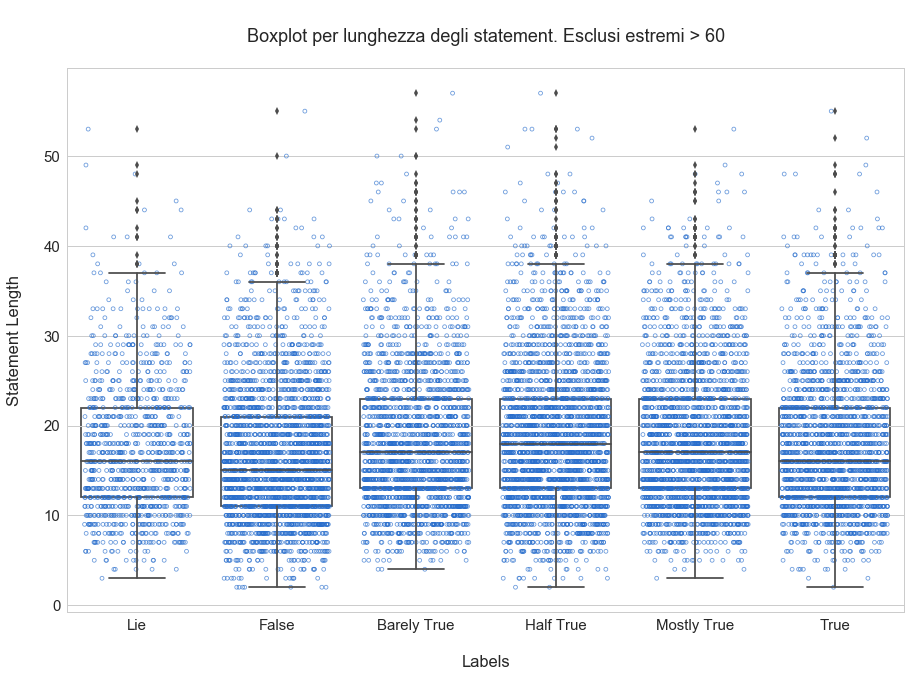

In [52]:
# Grafico escludendo i testi estremamente lunghi
ddf = ddf[ddf['statement_len'] < 60]

name = "../../plots/sLen_cut.pdf".format("ME")
pages = PdfPages(name)


plt.figure(figsize=(15, 10))
ax = sns.regplot(x = 'label', y = 'statement_len', data = ddf, fit_reg = False, 
                 x_jitter = .38, scatter_kws = m)
sns.boxplot( x = 'label', y = 'statement_len', data = ddf, boxprops = dict(facecolor = '#FFFFFF', alpha=1, zorder = 0) )
ax.set_title("\nBoxplot per lunghezza degli statement. Esclusi estremi > 60\n")
ax.set_xticklabels(['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True'])
ax.set(xlabel = '\nLabels\n', ylabel = 'Statement Length\n')

pages.savefig(bbox_inches='tight');pages.close()

In [53]:
# Frequenza labels per ogni stato
df =  df.dropna(subset = ['state'])
df.state = df.state.apply(lambda x: 'CA' if 'California' in x else x)
df.state = df.state.apply(lambda x: 'CO' if 'Colorado' in x else x)
df.state = df.state.apply(lambda x: 'WA' if 'District of Columbia' in x else x)
df.state = df.state.apply(lambda x: 'WA' if 'Washington' in x else x)
df.state = df.state.apply(lambda x: 'FL' if 'Florida' in x else x)
df.state = df.state.apply(lambda x: 'VA' if 'Virginia' in x else x)
df.state = df.state.apply(lambda x: 'VA' if 'Virgina' in x else x)
df.state = df.state.apply(lambda x: 'VA' if 'Virgiia' in x else x)
df.state = df.state.apply(lambda x: 'OH' if 'ohio' in x else x)
df.state = df.state.apply(lambda x: 'WI' if 'Wisconsin' in x else x)
df.state = df.state.apply(lambda x: 'TX' if 'Tex' in x else x)
df.state = df.state.apply(lambda x: 'TN' if 'Tennesse' in x else x)
df.state = df.state.apply(lambda x: 'RI' if 'Rhode island' in x else x)
df.state = df.state.apply(lambda x: 'RI' if 'Rhode Island' in x else x)
df.state = df.state.apply(lambda x: 'PA' if 'Pennsylvania' in x else x)
df.state = df.state.apply(lambda x: 'OR' if 'Oregon' in x else x)
df.state = df.state.apply(lambda x: 'NY' if 'New York' in x else x)
df.state = df.state.apply(lambda x: 'NH' if 'New Hampshire' in x else x)
df.state = df.state.apply(lambda x: 'MA' if 'Massachusetts' in x else x)
df.state = df.state.apply(lambda x: 'IL' if 'Illinois' in x else x)
df.state = df.state.apply(lambda x: 'GA' if 'Georgia' in x else x)
df.state = df.state.apply(lambda x: 'GA' if 'Atlanta' in x else x)
df.state = df.state.apply(lambda x: 'AL' if 'Alabama' in x else x)
df.state = df.state.apply(lambda x: 'AK' if 'Alaska' in x else x)
df.state = df.state.apply(lambda x: 'AZ' if 'Arizona' in x else x)
df.state = df.state.apply(lambda x: 'AR' if 'Arkansas' in x else x)
df.state = df.state.apply(lambda x: 'CT' if 'Connecticut' in x else x)
df.state = df.state.apply(lambda x: 'DE' if 'Delaware' in x else x)
df.state = df.state.apply(lambda x: 'HI' if 'Hawaii' in x else x)
df.state = df.state.apply(lambda x: 'ID' if 'Idaho' in x else x)
df.state = df.state.apply(lambda x: 'IN' if 'Indiana' in x else x)
df.state = df.state.apply(lambda x: 'IL' if 'Illinois' in x else x)
df.state = df.state.apply(lambda x: 'GA' if 'Georgia' in x else x)
df.state = df.state.apply(lambda x: 'GA' if 'Atlanta' in x else x)
df.state = df.state.apply(lambda x: 'AL' if 'Alabama' in x else x)
df.state = df.state.apply(lambda x: 'AK' if 'Alaska' in x else x)
df.state = df.state.apply(lambda x: 'AZ' if 'Arizona' in x else x)
df.state = df.state.apply(lambda x: 'AR' if 'Arkansas' in x else x)
df.state = df.state.apply(lambda x: 'CT' if 'Connecticut' in x else x)
df.state = df.state.apply(lambda x: 'DE' if 'Delaware' in x else x)
df.state = df.state.apply(lambda x: 'HI' if 'Hawaii' in x else x)
df.state = df.state.apply(lambda x: 'ID' if 'Idaho' in x else x)
df.state = df.state.apply(lambda x: 'IN' if 'Indiana' in x else x)
df.state = df.state.apply(lambda x: 'NJ' if 'New Jersey' in x else x)
df.state = df.state.apply(lambda x: 'NM' if 'New Mexico' in x else x)
df.state = df.state.apply(lambda x: 'NC' if 'North Carolina' in x else x)
df.state = df.state.apply(lambda x: 'ND' if 'North Dakota' in x else x)
df.state = df.state.apply(lambda x: 'OH' if 'Ohio' in x else x)
df.state = df.state.apply(lambda x: 'OK' if 'Oklahoma' in x else x)
df.state = df.state.apply(lambda x: 'SC' if 'South Carolina' in x else x)
df.state = df.state.apply(lambda x: 'SD' if 'South Dakota' in x else x)
df.state = df.state.apply(lambda x: 'UT' if 'Utah' in x else x)
df.state = df.state.apply(lambda x: 'VT' if 'Vermont' in x else x)
df.state = df.state.apply(lambda x: 'WY' if 'Wyoming' in x else x)
df.state = df.state.apply(lambda x: 'IA' if 'Iowa' in x else x)
df.state = df.state.apply(lambda x: 'KS' if 'Kansas' in x else x)
df.state = df.state.apply(lambda x: 'KY' if 'Kentucky' in x else x)
df.state = df.state.apply(lambda x: 'LA' if 'Louisiana' in x else x)
df.state = df.state.apply(lambda x: 'ME' if 'Maine' in x else x)
df.state = df.state.apply(lambda x: 'MD' if 'Maryland' in x else x)
df.state = df.state.apply(lambda x: 'MI' if 'Michigan' in x else x)
df.state = df.state.apply(lambda x: 'MN' if 'Minnesota' in x else x)
df.state = df.state.apply(lambda x: 'MS' if 'Mississippi' in x else x)
df.state = df.state.apply(lambda x: 'MO' if 'Missouri' in x else x)
df.state = df.state.apply(lambda x: 'MT' if 'Montana' in x else x)
df.state = df.state.apply(lambda x: 'NE' if 'Nebraska' in x else x)
df.state = df.state.apply(lambda x: 'NV' if 'Nevada' in x else x)
# drop not us rows
df = df[df['state'] != 'the United States']
df = df[df['state'] != 'United Kingdom']
df = df[df['state'] != 'Unknown']
df = df[df['state'] != 'Russia']
df = df[df['state'] != 'Qatar']
df = df[df['state'] != 'None']
df = df[df['state'] != 'China']
df_state = df.groupby(['state', 'label']).count()[['id_par']]
df_state = df_state.unstack();
df_state = df_state.fillna(0)
df_state.columns = ['barely_true', 'false', 'half_true', 'mostly_true', 'lie', 'true']
df_state = df_state[['lie', 'false', 'barely_true', 'half_true', 'mostly_true', 'true']]

for column in df_state:
    tot = df_state[column].sum()
    df_state[column] = df_state[column].apply(lambda x: round(x/tot, 4))

df_state.head(5)

,lie,false,barely_true,half_true,mostly_true,true
state,,,,,,
AK,0.0125,0.0134,0.0073,0.0057,0.0039,0.0089
AL,0.0031,0.0026,0.0024,0.0024,0.0010,0.0000
AR,0.0125,0.0062,0.0134,0.0120,0.0089,0.0107
AZ,0.0188,0.0247,0.0225,0.0206,0.0222,0.0256
CA,0.0219,0.0169,0.0146,0.0182,0.0256,0.0137


In [54]:
# Plot US Map
#usa_label_map(df_state, 'lie')
#usa_label_map(df_state, 'false')
#usa_label_map(df_state, 'barely_true')
#usa_label_map(df_state, 'half_true')
#usa_label_map(df_state, 'mostly_true')
#usa_label_map(df_state, 'true')

In [55]:
print_max_label(df_state, 'lie')
print_max_label(df_state, 'false')
print_max_label(df_state, 'barely_true')
print_max_label(df_state, 'half_true')
print_max_label(df_state, 'mostly_true')
print_max_label(df_state, 'true')

History Vector dell'elemento con maggior numero di lie in proporzione al totale di statements:
lie            0.1614
false          0.1181
barely_true    0.1430
half_true      0.1202
mostly_true    0.1142
true           0.1237
Name: TX, dtype: float64


History Vector dell'elemento con maggior numero di false in proporzione al totale di statements:
lie            0.1614
false          0.1181
barely_true    0.1430
half_true      0.1202
mostly_true    0.1142
true           0.1237
Name: TX, dtype: float64


History Vector dell'elemento con maggior numero di barely_true in proporzione al totale di statements:
lie            0.0893
false          0.1115
barely_true    0.1430
half_true      0.1293
mostly_true    0.1349
true           0.1095
Name: FL, dtype: float64


History Vector dell'elemento con maggior numero di half_true in proporzione al totale di statements:
lie            0.0893
false          0.1115
barely_true    0.1430
half_true      0.1293
mostly_true    0.1349
true           0.